Data source:
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

Objectives:
Build a multi-headed model capable of detecting and assigning probabilities for different types of of toxicity such as:
1. toxic
2. severe toxic
3. obscene
4. threat
5. insult
6. identity hate

The dataset comprises of comments from Wikipedia's talk page (ie. discussion) pages.

### Import relevant libraries and load the data

In [ ]:
# Import relevant packages
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re
import pandas as pd
import string
import seaborn as sns

from nltk.corpus import stopwords  # Remove useless words
from nltk.stem.lancaster import LancasterStemmer  # Convert words to base form; aggressive

# Import packages that help us to create document-term matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

* NOTE: each function will be explained when used.


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raksh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Stopwords are a list of 'useless' words
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

### Loading the train and test files and take a peek at 1st 5 rows.

In [ ]:
train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Entries with all 0 under the 6 categories are neutral and considered as non-toxic.

In [ ]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


A common preprocessing step is to check for nulls, and fill the null values with something before proceeding to the next steps. If you leave the null values intact, it will affect the model results

In [ ]:
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool,
 id              False
 comment_text    False
 dtype: bool)

Looks like we don't need to deal with the null values.  Sweet!

### Let's see how the 1st 3 comments look like

In [ ]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
train['comment_text'][1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [ ]:
train['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

### Exploratory Data Analysis

In [ ]:
# Check percentage of comments that are toxic compared to normal comments
train.toxic.value_counts(normalize=True)

0    0.904156
1    0.095844
Name: toxic, dtype: float64

Cool. It seems that 90% of the comments fall in the toxic category.

In [ ]:
#Create a new subset of the data by only taking the 2nd column onwards (comments and categories)
data_count=train.iloc[:,2:].sum()
data_count

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

C:\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


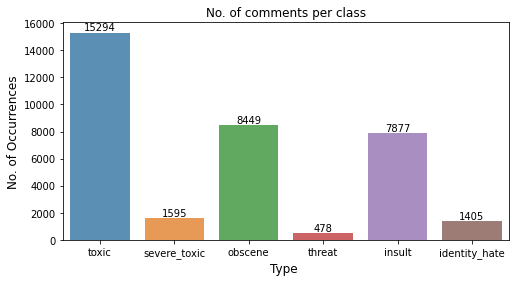

In [ ]:
# Plot a chart with the following size
plt.figure(figsize=(8,4))

# Plot a bar chart using the index (category values) and the count of each category. alpha = 0.8 to make the bars more translucent
ax = sns.barplot(data_count.index, data_count.values, alpha=0.8)

plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

#adding the text labels for each bar
rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [ ]:
num_rows = len(train)
print(num_rows)

159571


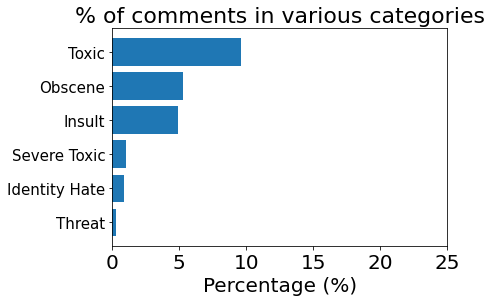

In [ ]:
# Create a bar graph
sum_tox = train['toxic'].sum() / num_rows * 100
sum_sev = train['severe_toxic'].sum() / num_rows * 100
sum_obs = train['obscene'].sum() / num_rows * 100
sum_thr = train['threat'].sum() / num_rows * 100
sum_ins = train['insult'].sum() / num_rows * 100
sum_ide = train['identity_hate'].sum() / num_rows * 100

# Initiate a list of 6 values that represent the 6 x-axis values for the categories
ind = np.arange(6)

# Let the ind variable be the x-axis, whereas the % of toxicity for each category be the y-axis.
# Sequence of % have been sorted manually. This method cannot be done if there are large numbers of categories.
ax = plt.barh(ind, [sum_tox, sum_obs, sum_ins, sum_sev, sum_ide, sum_thr])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=22)
plt.yticks(ind, ('Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 'Threat', ), size=15)

# Invert the graph so that it is in descending order.
plt.gca().invert_yaxis()
plt.show()


### Preprocess the text

In [ ]:
data = train

In [ ]:
# Text preprocessing steps - remove numbers, capital letters, punctuation, '\n'
import re
import string

# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
data['comment_text'] = data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

data['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

Separate our dataset into 6 sections. Each section is comment + 1 category.

In [ ]:
data_tox = data.loc[:,['id','comment_text','toxic']]
print(data_tox['comment_text'][0])

explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        


In [ ]:
data_sev = data.loc[:,['id','comment_text','severe_toxic']]
data_obs = data.loc[:,['id','comment_text','obscene']]
data_thr = data.loc[:,['id','comment_text','threat']]
data_ins = data.loc[:,['id','comment_text','insult']]
data_ide = data.loc[:,['id','comment_text','identity_hate']]

### Creating WordCloud
Useful to show the words which occur most frequently for each category.

In [ ]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [ ]:
def wordcloud(df, label):

    # Print only rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

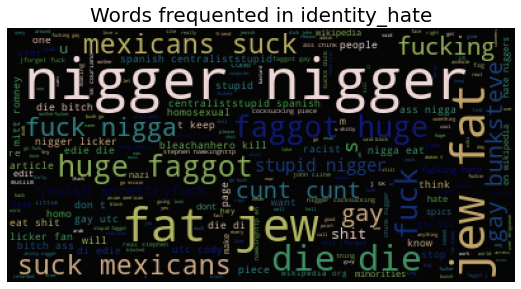

In [ ]:
wordcloud(data_ide,'identity_hate')

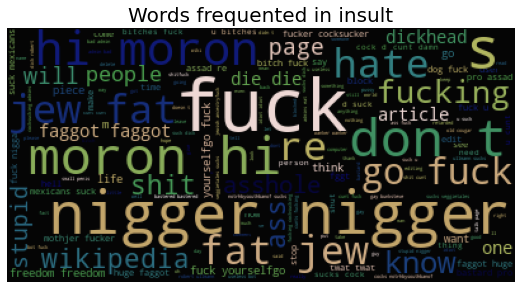

In [ ]:
wordcloud(data_ins, 'insult')

- Earlier, we saw that comments that are toxic (and other forms of toxicity) make up less than 10% of the comments in the data. This leads to the issue of class imbalance.

- We can deal with class imbalance by taking a subset of the data where the proportion of the toxic comments are at least 20% (ideally 50%) in relation to non-toxic comments.

- For a start, we can take 5000 rows of comments that are toxic and concatenate them row-wise with those that are not toxic so that we have a balanced dataset.

In [ ]:
data_tox.head()

,id,comment_text,toxic
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


In [ ]:
# toxic comments with value 1
data_tox_1 = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:]
data_tox_1.shape

(5000, 3)

In [ ]:
# toxic comments with value 0
data_tox_0 = data_tox[data_tox['toxic'] == 0].iloc[0:5000,:]

In [ ]:
# Balanced data toxic
data_tox_done = pd.concat([data_tox_1, data_tox_0], axis=0)
data_tox_done.shape

(10000, 3)

### Not all categories have 5000 rows. So we should count them first and make them balanced.

In [ ]:
data_sev[data_sev['severe_toxic'] == 1].count()

id              1595
comment_text    1595
severe_toxic    1595
dtype: int64

In [ ]:
data_sev_1 = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1595,:]
data_sev_0 = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1595,:]
data_sev_done = pd.concat([data_sev_1, data_sev_0], axis=0)
data_sev_done.shape

(3190, 3)

Cool. We only had 1,595 comments that are severely toxic. We combine it together with another 1,595 comments that are not toxic to form a new dataset that is balanced. We repeat this for all other categories.

In [ ]:
data_obs[data_obs['obscene'] == 1].count()

id              8449
comment_text    8449
obscene         8449
dtype: int64

In [ ]:
data_obs_1 = data_obs[data_obs['obscene'] == 1].iloc[0:5000,:]
data_obs_0 = data_obs[data_obs['obscene'] == 0].iloc[0:5000,:]
data_obs_done = pd.concat([data_obs_1, data_obs_0], axis=0)
data_obs_done.shape

(10000, 3)

In [ ]:
data_thr[data_thr['threat'] == 1].count()

id              478
comment_text    478
threat          478
dtype: int64

The number of threat comments of 478 is too miniscule when addded with another 478 clean comments for a proper analysis. We decided that the clean comments will comprise 80% at the most of the dataset, as shown below.

In [ ]:
data_thr_1 = data_thr[data_thr['threat'] == 1].iloc[0:478,:]

# We include 1912 comments that have no threat so that the data with threat (478) will represent 20% of the dataset.
data_thr_0 = data_thr[data_thr['threat'] == 0].iloc[0:1912,:]
data_thr_done = pd.concat([data_thr_1, data_thr_0], axis=0)
data_thr_done.shape

(2390, 3)

In [ ]:
data_ins[data_ins['insult'] == 1].count()

id              7877
comment_text    7877
insult          7877
dtype: int64

In [ ]:
data_ins_1 = data_ins[data_ins['insult'] == 1].iloc[0:5000,:]
data_ins_0 = data_ins[data_ins['insult'] == 0].iloc[0:5000,:]
data_ins_done = pd.concat([data_ins_1, data_ins_0], axis=0)
data_ins_done.shape

(10000, 3)

In [ ]:
data_ide[data_ide['identity_hate'] == 1].count()

id               1405
comment_text     1405
identity_hate    1405
dtype: int64

In [ ]:
data_ide_1 = data_ide[data_ide['identity_hate'] == 1].iloc[0:1405,:] # 20%
data_ide_0 = data_ide[data_ide['identity_hate'] == 0].iloc[0:5620,:] # 80%
data_ide_done = pd.concat([data_ide_1, data_ide_0], axis=0)
data_ide_done.shape

(7025, 3)

Reminder: Number of comments that fall into the following categories:

- Toxic (14,000+)
- Severe Toxic (1595)
- Obscene (8449)
- Threat (478)
- Insult (7877)
- Identity Hate (1405)

#### df_****_done refers to the dataframes of each class that has been balanced (at least 20/80 proportion)

|                      | DF name       | No. of pts (1) | No. of pts (0) | Total data pts |
|----------------------|---------------|----------------|----------------|----------------|
| Toxic                | data_tox_done | 5000           | 5000           | 10000          |
| Severe Toxic         | data_sev_done | 1595           | 1595           | 3190           |
| Obscene (8449)       | data_obs_done | 5000           | 5000           | 10000          |
| Threat (478)         | data_thr_done | 478            | 1912           | 2390           |
| Insult (7877)        | data_ins_done | 5000           | 5000           | 10000          |
| Identity Hate (1405) | data_ide_done | 1405           | 5620           | 7025           |

### Import relevant packages for modelling

In [ ]:
# Import packages for pre-processing
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

# Import tools to split data and evaluate model performance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# Import ML algos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


Create simple function that takes in a dataset and allows user to choose dataset, toxicity label, vectorizer and number of ngrams

In [ ]:
def cv_tf_train_test(df_done,label,vectorizer,ngram):

    ''' Train/Test split'''
    # Split the data into X and y data sets
    X = df_done.comment_text
    y = df_done[label]

    # Split our data into training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    ''' Count Vectorizer/TF-IDF '''

    # Create a Vectorizer object and remove stopwords from the table
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')

    X_train_cv1 = cv1.fit_transform(X_train) # Learn the vocabulary dictionary and return term-document matrix
    X_test_cv1  = cv1.transform(X_test)      # Learn a vocabulary dictionary of all tokens in the raw documents.

    # Output a Dataframe of the CountVectorizer with unique words as the labels
    # test = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names())

    ''' Initialize all model objects and fit the models on the training data '''
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    print('lr done')

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)

    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    print('bnb done')

    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    print('mnb done')

    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_train_cv1, y_train)
    print('rdf done')

    # Create a list of F1 score of all models
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test),
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]}

    # Create DataFrame with the model names as column labels
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])

    return df_f1


Let's create a TF-IDF vectorizer object for each category and calculate the F1 scores across all models

In [ ]:
import time

t0 = time.time()

df_tox_cv = cv_tf_train_test(data_tox_done, 'toxic', TfidfVectorizer, (1,1))
df_tox_cv.rename(columns={'F1 Score': 'F1 Score(toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_tox_cv

lr done
bnb done
mnb done
rdf done
Time taken: 10.968498229980469 seconds


,F1 Score(toxic)
Log Regression,0.861234
KNN,0.185120
BernoulliNB,0.776521
MultinomialNB,0.874958
SVM,0.876133
Random Forest,0.838055


In [ ]:
t0 = time.time()

df_sev_cv = cv_tf_train_test(data_sev_done, 'severe_toxic', TfidfVectorizer, (1,1))
df_sev_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_sev_cv

lr done
bnb done
mnb done
rdf done
Time taken: 1.7197201251983643 seconds


,F1 Score(severe_toxic)
Log Regression,0.927879
KNN,0.857416
BernoulliNB,0.803707
MultinomialNB,0.936170
SVM,0.926004
Random Forest,0.934874


In [ ]:
t0 = time.time()

df_obs_cv = cv_tf_train_test(data_obs_done, 'obscene', TfidfVectorizer, (1,1))
df_obs_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_obs_cv

lr done
bnb done
mnb done
rdf done
Time taken: 8.15196704864502 seconds


,F1 Score(obscene)
Log Regression,0.908655
KNN,0.519056
BernoulliNB,0.787830
MultinomialNB,0.901463
SVM,0.921378
Random Forest,0.909091


In [ ]:
t0 = time.time()

df_thr_cv = cv_tf_train_test(data_thr_done, 'threat', TfidfVectorizer, (1,1))
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_thr_cv

lr done
bnb done
mnb done
rdf done
Time taken: 1.2882466316223145 seconds


,F1 Score(threat)
Log Regression,0.628821
KNN,0.720000
BernoulliNB,0.311828
MultinomialNB,0.504762
SVM,0.786765
Random Forest,0.795539


In [ ]:
t0 = time.time()

df_ins_cv = cv_tf_train_test(data_ins_done, 'insult', TfidfVectorizer, (1,1))
df_ins_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ins_cv

lr done
bnb done
mnb done
rdf done
Time taken: 9.424309253692627 seconds


,F1 Score(insult)
Log Regression,0.896599
KNN,0.257992
BernoulliNB,0.783762
MultinomialNB,0.897411
SVM,0.902619
Random Forest,0.883993


In [ ]:
t0 = time.time()

df_ide_cv = cv_tf_train_test(data_ide_done, 'identity_hate', TfidfVectorizer, (1,1))
df_ide_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ide_cv

lr done
bnb done
mnb done
rdf done
Time taken: 5.166263818740845 seconds


,F1 Score(identity_hate)
Log Regression,0.699029
KNN,0.230159
BernoulliNB,0.549206
MultinomialNB,0.485857
SVM,0.797516
Random Forest,0.768448


In [ ]:
# Let's combine the dataframes into a master dataframe to compare F1 scores across all categories.
f1_all = pd.concat([df_tox_cv, df_sev_cv, df_obs_cv, df_ins_cv, df_thr_cv, df_ide_cv], axis=1)

#Transpose the combined F1 dataframe to make it suitable for presentation on a graph
f1_all_trp = f1_all.transpose()
f1_all_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
F1 Score(toxic),0.861234,0.185120,0.776521,0.874958,0.876133,0.838055
F1 Score(severe_toxic),0.927879,0.857416,0.803707,0.936170,0.926004,0.934874
F1 Score(obscene),0.908655,0.519056,0.787830,0.901463,0.921378,0.909091
F1 Score(insult),0.896599,0.257992,0.783762,0.897411,0.902619,0.883993
F1 Score(threat),0.628821,0.720000,0.311828,0.504762,0.786765,0.795539
F1 Score(identity_hate),0.699029,0.230159,0.549206,0.485857,0.797516,0.768448


Text(0.5, 1.0, 'F1 Score of ML models (TF-IDF)')

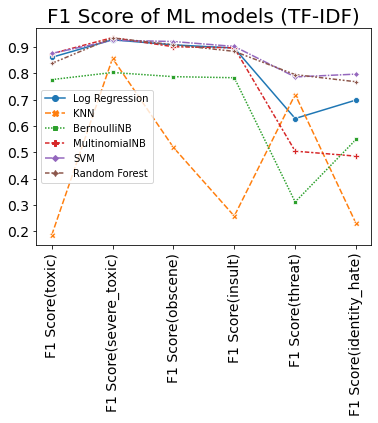

In [ ]:
sns.lineplot(data=f1_all_trp, markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score of ML models (TF-IDF)', fontsize=20)

LinearSVC and Random Forest models perform best (purple and brown lines seem to be the highest).

### Testing. Probability of the comment falling in various categories should be output.

In [ ]:
X = data_tox_done.comment_text
y = data_tox_done['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format

randomforest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train our SVM model with the X training data converted into Count Vectorized format with the Y training data
randomforest.fit(X_train_fit, y_train)
randomforest.predict(X_test_fit)

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [ ]:
# Sample Prediction
comment1 = ['You piece of shit']
comment2 = ['What is up garden apple doing']

comment1_vect = tfv.transform(comment1)
randomforest.predict_proba(comment1_vect)[:,1]

array([1.])

In [ ]:
randomforest.predict_proba(comment1_vect)

array([[0., 1.]])

In [ ]:
comment2_vect = tfv.transform(comment2)
randomforest.predict_proba(comment2_vect)[:,1]

array([0.16036935])

Random forest has assigned a probability of 1 that comment 1 ('you piece of shit') is toxic. Comment 2 has only a low toxicity probability of 0.16.

Produce result and submission to kaggle

In [ ]:
sample_sub=pd.read_csv('Dataset/sample_submission.csv')
sample_sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
column_list = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
data_list = [data_tox_done, data_sev_done, data_obs_done, data_thr_done, data_ins_done, data_ide_done]

In [ ]:

for i in range(len(data_list)):
    X = data_list[i].comment_text
    y = data_list[i][column_list[i]]

    X_test = test.comment_text

    tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
    X = tfv.fit_transform(X)  # Convert the X data into a document term matrix dataframe
    X_test = tfv.transform(X_test)
    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X, y)
    probability = randomforest.predict_proba(X_test)[:,1]
    sample_sub[column_list[i]] = probability



In [ ]:
sample_sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.940000,0.890000,0.920000,0.67,0.940000,0.810000
1,0000247867823ef7,0.244523,0.265595,0.158281,0.11,0.102650,0.098724
2,00013b17ad220c46,0.059251,0.098286,0.127924,0.01,0.195705,0.093902
3,00017563c3f7919a,0.100000,0.130000,0.070000,0.03,0.100000,0.010000
4,00017695ad8997eb,0.250000,0.220000,0.440000,0.16,0.350000,0.050000


In [ ]:
sample_sub.to_csv('ml_approach_sub.csv', index=False)

# Deep Learning Approach

Let's clean the text

In [ ]:
train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')

* Punctuation remove

In [ ]:
#string.punctuation


In [ ]:
#def remove_punct(text):
#    text  = "".join([char for char in text if char not in string.punctuation])
 #   text = re.sub('[0-9]+', '', text)
  #  text = re.sub('\n', '', text)
   # text = re.sub('\t', '', text)
    #return text


#train['comment_text'] = train['comment_text'].apply(lambda x: remove_punct(x))
#test['comment_text'] = test['comment_text'].apply(lambda x: remove_punct(x))




* removing uppercases

In [ ]:
# def lower(text):
#     lowercase_text = [word.lower() for word in text.split()]
#     text=" ".join(lowercase_text)
#     return text

In [ ]:
# train['comment_text'] = train['comment_text'].apply(lambda x: lower(x))
# test['comment_text'] = test['comment_text'].apply(lambda x: lower(x))


## Insight

Removing punctuations and lower cases will lower the score after checking the data more i found out that the punctuations are used to express such bad words for example s#$t


In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

the dependent variables are in the training set itself so we need to split them up, into X and Y sets.

we going to  feed the comments into the LSTM as part of the neural network but we can't just feed the words as it is.

So we are going to do a natural language processing to the comments which are simply explained as :

1. Tokenization - We need to break down the sentence into unique words. For eg, "I love cats and love dogs" will become ["I","love","cats","and","dogs"]
2. Indexing - We put the words in a dictionary-like structure and give them an index each For eg, {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}
3. Index Representation- We could represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM. For eg, [1,2,3,4,2,5]

Note that we have to define the number of unique words in our dictionary when tokenizing the sentences
* we picked 20000

In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

the occurrence and the index of each words in the dictionary:
it takes alot of time to execute and alot of output is shown uncomment to check

In [ ]:
#for occurence of words
#tokenizer.word_counts
#for index of words
#tokenizer.word_index

checking "list_tokenized_train"  you will see that Keras has turned our words into index representation for us



In [ ]:
list_tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

And we have to feed a stream of data that has a consistent length(fixed number of features)
and here we will face a problem since the comments aren't all equal so
example:

Comment #1: [8,9,3,7,3,6,3,6,3,6,2,3,4,9]

Comment #2: [1,2]

as a solution we will use padding that will make all comments having the same length by filling with missing values with zeros to get :

Comment #1: [8,9,3,7,3,6,3,6,3,6,2,3,4,9]

Comment #2: [1,2,0,0,0,0,0,0,0,0,0,0,0,0]

and now another problem how can we choose the fixed number of features since  if you put it too short, you might lose some useful feature that could cost you some accuracy points down the path.If you put it too long, your LSTM cell will have to be larger to store the possible values or states.




One of the ways to go about it is to see the distribution of the number of words in sentences.

In [ ]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

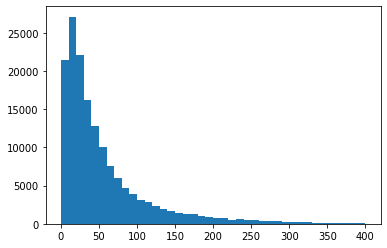

In [ ]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

As we can see, most of the sentence length is about 30+. We could set the "maxlen" to about 50.
and to avoid any kind of information loss we can extend it to 200

In [ ]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

our comments are now econded and ready to fed to the model


# Building model

General architecture of our model

**Input Layer**
* the inputs into our networks are our list of encoded sentences. We begin our defining an Input layer that accepts a list of sentences that has a dimension of 200.

In [ ]:
inp = Input(shape=(maxlen, ))

By indicating an empty space after comma, we are telling Keras to infer the number automatically.

**Embedding layer**

Next, we pass it to our Embedding layer, where we project the words to a defined vector space depending on the distance of the surrounding words in a sentence. Embedding allows us to reduce model size and most importantly the huge dimensions we have to deal with instead of  using one-hot encoding to represent the words in our sentence.

In [ ]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

*  the embedding size (vector size) is a parameter that you can tune and experiment
*  embedding function will return us a  3-D tensor
*  Tensors are simply mathematical objects that can be used to describe physical properties, just like   scalars and vectors. In fact tensors are merely a generalisation of scalars and vectors; a scalar  is a zero rank tensor, and a vector is a first rank tensor.

* Next, we feed this Tensor into the LSTM layer. We set the LSTM to produce an output that has a dimension of 60 and want it to return the whole unrolled sequence of results
* LSTM or RNN works by recursively feeding the output of a previous network into the input of the current network, and you would take the final output after X number of recursion. But depending on use cases, you might want to take the unrolled, or the outputs of each recursion as the result to pass to the next layer. And this is the case.

LSTM takes in a tensor of [Batch Size, Time Steps, Number of Inputs]. Batch size is the number of samples in a batch, time steps is the number of recursion it runs for each input, or it could be pictured as the number of "A"s in the above picture. Lastly, number of inputs is the number of variables(number of words in each sentence in our case) you pass into LSTM as pictured in "x" above.

In [ ]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

What it does is going through the samples, recursively run the LSTM model for many time (depending on the values of the tensor passed from the last cell stocked in x) , passing in the coordinates of the words each time. And because we want the unrolled version, we will receive a Tensor shape of (None, 1, 1), where 60 is the output dimension we have defined.

**Max Pooling**

Before we could pass the output to a normal layer, we need to reshape the 3D tensor into a 2D one. We reshape carefully to avoid throwing away data that is important to us, and ideally we want the resulting data to be a good representative of the original data.

Therefore, we use a Global Max Pooling layer which is traditionally used in CNN problems to reduce the dimensionality of image data. In simple terms, we go through each patch of data, and we take the maximum values of each patch. These collection of maximum values will be a new set of down-sized data we can use.

In [ ]:
x = GlobalMaxPool1D()(x)

Now we move to regularization our neurol network (to reduce overfitting by using dropout and dense layers)

having a 2D tensor, we pass it to a Dropout layer which indiscriminately "disable" some nodes so that the nodes in the next layer is forced to handle the representation of the missing data and the whole network could result in better generalization.



In [ ]:
x = Dropout(0.1)(x)

We set the dropout layer to drop out 10% of the nodes.

After a drop out layer, we connect the output of drop out layer to a densely connected layer and the output passes through a RELU function. In short, this is what it does:
Activation( (Input X Weights) + Bias)


The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.

In [ ]:
x = Dense(50, activation="relu")(x)

We feed the output into a Dropout layer again.



In [ ]:
x = Dropout(0.1)(x)

Finally, we feed the output into a Sigmoid layer. The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) for each of the 6 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.



In [ ]:
x = Dense(6, activation="sigmoid")(x)

All is left is to define the inputs, outputs and configure the learning process. We have set our model to optimize our loss function using Adam optimizer, define the loss function to be "binary_crossentropy" since we are tackling a binary classification.And learning rateby his default value  set at 0.001.

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

 lists out all your layer outputs

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 128)          2560000   
                                                                 
 lstm_layer (LSTM)           (None, 200, 60)           45360     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 60)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                3050      
                                                           

It's finally time to put our model to the test. We'll feed in a list of 32 padded, indexed sentence for each batch and split 10% of the data as a validation set. This validation set will be used to assess whether the model has overfitted, for each batch. The model will also run for 2 epochs ( in other word it will run through the whole training set 2 times ).

In [ ]:
batch_size = 32
epochs = 5
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
4488/4488 [==============================] - 626s 138ms/step - loss: 0.0696 - accuracy: 0.9405 - val_loss: 0.0497 - val_accuracy: 0.9939
Epoch 2/5
4488/4488 [==============================] - 586s 131ms/step - loss: 0.0441 - accuracy: 0.9863 - val_loss: 0.0475 - val_accuracy: 0.9932
Epoch 3/5
4488/4488 [==============================] - 651s 145ms/step - loss: 0.0383 - accuracy: 0.9727 - val_loss: 0.0480 - val_accuracy: 0.9930
Epoch 4/5
4488/4488 [==============================] - 646s 144ms/step - loss: 0.0338 - accuracy: 0.9713 - val_loss: 0.0487 - val_accuracy: 0.9926
Epoch 5/5
4488/4488 [==============================] - 628s 140ms/step - loss: 0.0295 - accuracy: 0.9056 - val_loss: 0.0517 - val_accuracy: 0.9930


Checking the model

In [ ]:
comment1='what the fuck'
tokenize_comment = tokenizer.texts_to_sequences([comment1])
final_comment = pad_sequences(tokenize_comment, maxlen=maxlen)

result = model.predict(final_comment)
print(result)

[[9.9200773e-01 1.3491881e-01 9.7885823e-01 3.7667155e-04 3.8686493e-01
  4.6965778e-03]]


Predicting with our model

In [ ]:
sub=pd.read_csv('Dataset/sample_submission.csv')
sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
preds = model.predict(X_te, batch_size=1024)
sub[list_classes] = preds

In [ ]:
sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998387,2.842159e-01,9.794293e-01,9.879449e-02,9.505817e-01,3.178706e-01
1,0000247867823ef7,0.000010,5.019755e-10,3.584091e-07,1.677146e-08,3.156398e-07,1.421973e-07
2,00013b17ad220c46,0.000075,1.971975e-07,1.167660e-05,1.261492e-06,1.110833e-05,8.022992e-06
3,00017563c3f7919a,0.003263,8.235146e-07,2.366602e-04,8.538566e-06,2.180934e-04,1.736500e-05
4,00017695ad8997eb,0.000063,5.996201e-08,4.356068e-06,1.353179e-06,4.008251e-06,8.678208e-06


In [ ]:
sub.to_csv('dl_approach_submission.csv',index=False)

### Pickling the tokenizer and LSTM model for flask application

In [ ]:
import pickle

In [ ]:
with open(r"{}.pkl".format('tokenizer'), "wb") as f:
        pickle.dump(tokenizer, f)

In [ ]:
# using keras save method to save all the weights learn by the model in a h5 format
model.save('lstm_model'+'.h5')